In [2]:
!pip install -q tensorflow-gpu

     |████████████████████████████████| 516.2MB 32kB/s 


In [3]:
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from numpy import array

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load del dataset
Dataset contains data of 9 days of temperature, humidity, pressure and number of people. It contains a sampe every 5 minutes, so there are 288(12x24) points in a day. 


In [1]:
# df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/SafeLab/dataframe.csv")
# df.time = pd.to_datetime(df.time, dayfirst = True)
# time = df['time'].values

# df['time'] = pd.to_datetime(df.time , format = '%d/%m/%Y %H.%M.%S')
# df.set_index('time',inplace=True)
# points_per_day = 288 

df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/SafeLab/climate.csv")

df.tail()

NameError: ignored

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [49]:
TRAIN_SPLIT = len(df)-2*points_per_day

In [50]:
tf.random.set_seed(42)

# Forcast univariate timeserie
In this section we are going to make predictions only on temperature values


In [9]:
uni_data = df['temperature']
uni_data.index = df.index
uni_data.head()

time
2020-07-07 12:10:00+00:00    29.25
2020-07-07 12:15:00+00:00    29.40
2020-07-07 12:20:00+00:00    29.40
2020-07-07 12:25:00+00:00    29.40
2020-07-07 12:30:00+00:00    29.40
Name: temperature, dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e374b7cc0>],
      dtype=object)

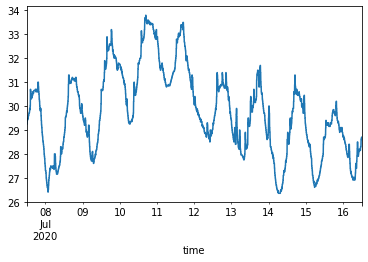

In [10]:
uni_data.plot(subplots=True)

## Standardize the data


In [11]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

We are going to create for each value a pair x, y where x represents the window before the value and y represents the value to predict. The model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step.


In [12]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [13]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.46424421]
 [-0.38053806]
 [-0.38053806]
 [-0.38053806]
 [-0.38053806]
 [-0.35263601]
 [-0.35263601]
 [-0.35263601]
 [-0.35263601]
 [-0.32473396]
 [-0.32473396]
 [-0.26892986]
 [-0.26892986]
 [-0.26892986]
 [-0.26892986]
 [-0.21312576]
 [-0.21312576]
 [-0.21312576]
 [-0.21312576]
 [-0.18522371]]

 Target temperature to predict
-0.18522370624199214


In [14]:
def create_time_steps(length):
  return list(range(-length, 0))

In [15]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

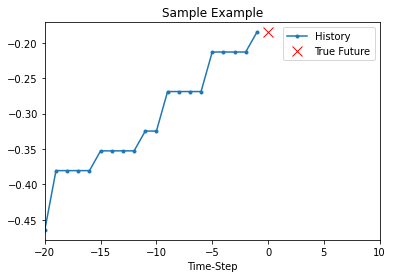

In [16]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [17]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


## Define the LSTM model


In [18]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [19]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [20]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3738 - val_loss: 0.1738
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1017 - val_loss: 0.0751
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0662 - val_loss: 0.0544
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0499 - val_loss: 0.0428
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0418 - val_loss: 0.0368
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0371 - val_loss: 0.0334
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0341 - val_loss: 0.0313
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0322 - val_loss: 0.0301
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0313 - val_loss: 0.0294
Epoch 10/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0309 - val_loss: 0.0295

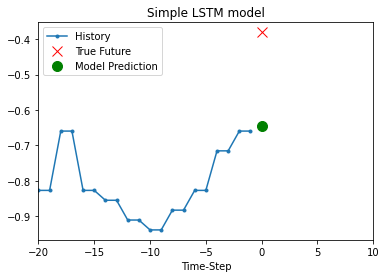

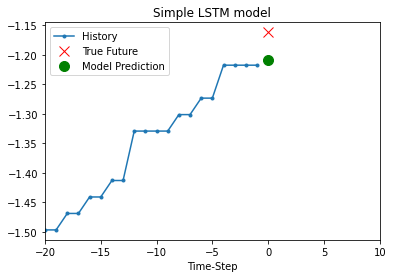

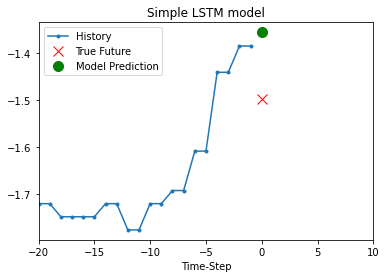

In [21]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

# Forecast a multivariate time series

In [22]:
features_considered = ['pressure', 'temperature', 'humidity']
features = df[features_considered]
features.index = df.index
features.head()

,pressure,temperature,humidity
time,,,
2020-07-07 12:10:00+00:00,1019.5,29.25,46.9
2020-07-07 12:15:00+00:00,1019.5,29.40,46.8
2020-07-07 12:20:00+00:00,1019.5,29.40,46.8
2020-07-07 12:25:00+00:00,1019.5,29.40,46.5
2020-07-07 12:30:00+00:00,1019.5,29.40,46.5


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6dd65a76d8>,
      dtype=object)

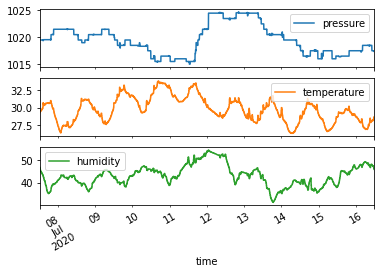

In [23]:
features.plot(subplots=True)

In [24]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [59]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  print(range(start_index, end_index))
  print(start_index - end_index)

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [62]:
past_history = 288
future_target = 144
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

range(288, 2015)
-1727
range(2303, 2447)
-144


In [63]:
print ('Single window of past history : {}'.format(x_train_single.shape))
print ('Single window of past history : {}'.format(x_val_single.shape))

Single window of past history : (1727, 288, 3)
Single window of past history : (144, 288, 3)


In [28]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

## Creating model

In [29]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [30]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

print(val_data_single.take(0))

(144, 1)
<TakeDataset shapes: ((None, 24, 3), (None,)), types: (tf.float64, tf.float64)>


In [31]:
EPOCHS=10
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.2570 - val_loss: 1.2465
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1093 - val_loss: 1.3696
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1024 - val_loss: 1.3372
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0968 - val_loss: 1.4080
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0936 - val_loss: 1.3509
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0911 - val_loss: 1.3392
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0892 - val_loss: 1.3021
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0879 - val_loss: 1.3041
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0869 - val_loss: 1.2773
Epoch 10/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0857 - val_loss: 1.2474

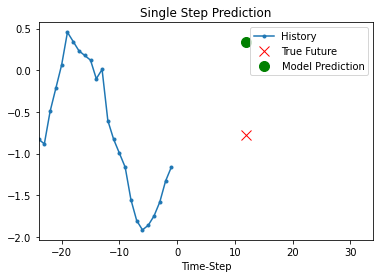

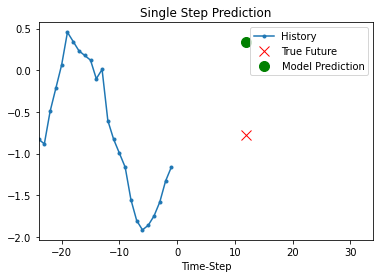

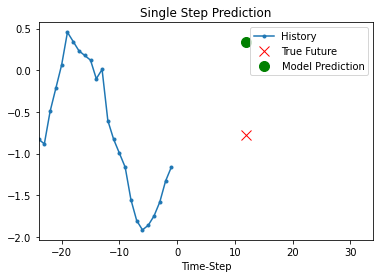

In [32]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

# Multi-Step model

In [177]:
past_history = 288
future_target = 24
STEP = 2
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

range(288, 2015)
-1727
range(2303, 2567)
-264


In [178]:
print ('Single window of past history : {}'.format(x_train_multi.shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi.shape))

Single window of past history : (1727, 144, 3)

 Target temperature to predict : (1727, 24)


In [179]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [180]:
def multi_step_plot(history, true_future, prediction):
  
  history_t = (uni_train_std*history) + uni_train_mean
  true_future_t = (uni_train_std*true_future) + uni_train_mean
  prediction_t = (uni_train_std*prediction) + uni_train_mean

  plt.figure(figsize=(20, 10))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history_t[:, 1]), label='History T')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future_t), 'bo',
           label='True Future T')
  if prediction_t.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction_t), 'ro',
             label='Predicted Future T')
  plt.legend(loc='upper left')

  #plt.plot(num_in, np.array(history[:, 1]), label='History')
  #plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
  #         label='True Future')
  #if prediction.any():
  #  plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
  #           label='Predicted Future')
  #plt.legend(loc='upper left')
  #plt.show()

## Plot history and future data are sampled every hour

ValueError: ignored

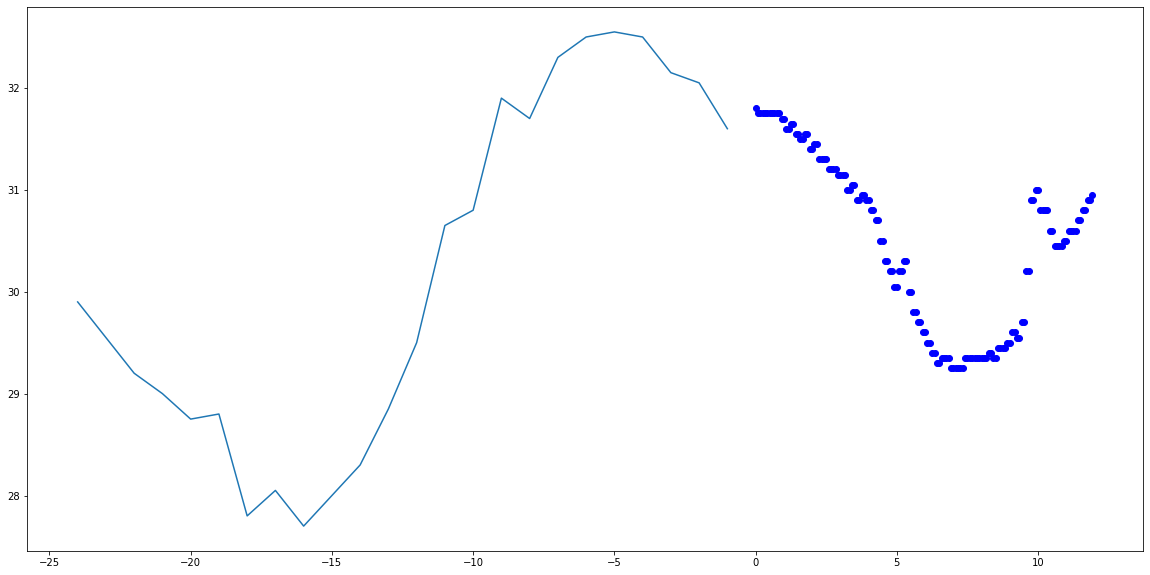

In [149]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

## Define the model

An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence.

We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

In [181]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))

multi_step_model.add(tf.keras.layers.Dense(24))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [182]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)
  

(256, 24)


In [183]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)


Epoch 1/10
200/200 [==============================] - 43s 213ms/step - loss: 0.5003 - val_loss: 0.9332
Epoch 2/10
200/200 [==============================] - 42s 209ms/step - loss: 0.1917 - val_loss: 0.7012
Epoch 3/10
200/200 [==============================] - 44s 222ms/step - loss: 0.1298 - val_loss: 0.7330
Epoch 4/10
200/200 [==============================] - 44s 220ms/step - loss: 0.1098 - val_loss: 0.7131
Epoch 5/10
200/200 [==============================] - 43s 217ms/step - loss: 0.1018 - val_loss: 0.6196
Epoch 6/10
200/200 [==============================] - 42s 211ms/step - loss: 0.0974 - val_loss: 0.5588
Epoch 7/10
200/200 [==============================] - 43s 217ms/step - loss: 0.0939 - val_loss: 0.5730
Epoch 8/10
200/200 [==============================] - 45s 224ms/step - loss: 0.0907 - val_loss: 0.5859
Epoch 9/10
200/200 [==============================] - 43s 215ms/step - loss: 0.0875 - val_loss: 0.5395
Epoch 10/10
200/200 [==============================] - 40s 201ms/step - l

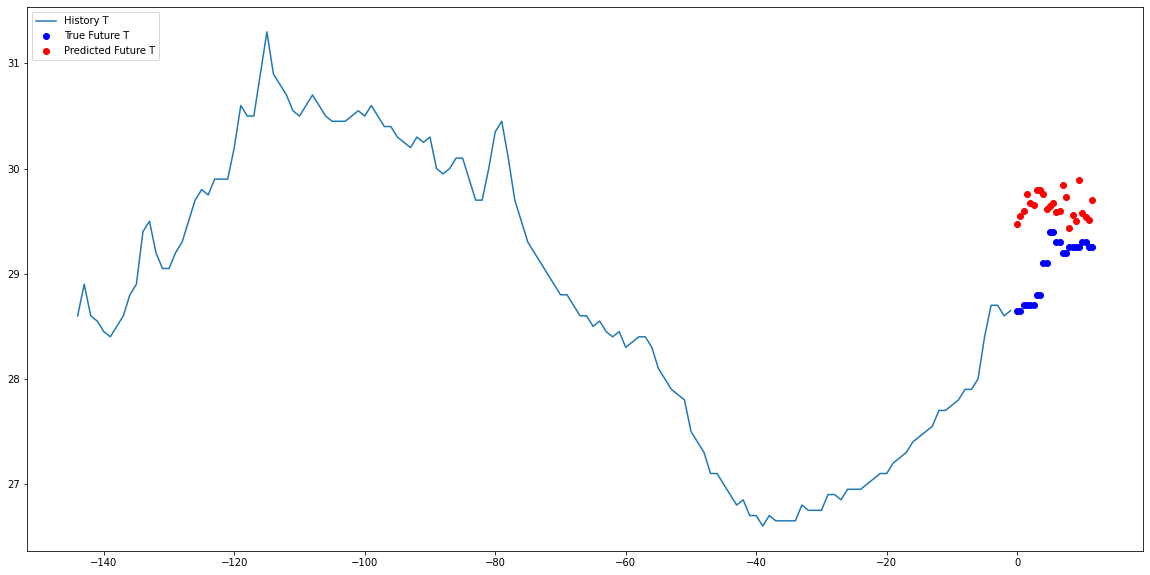

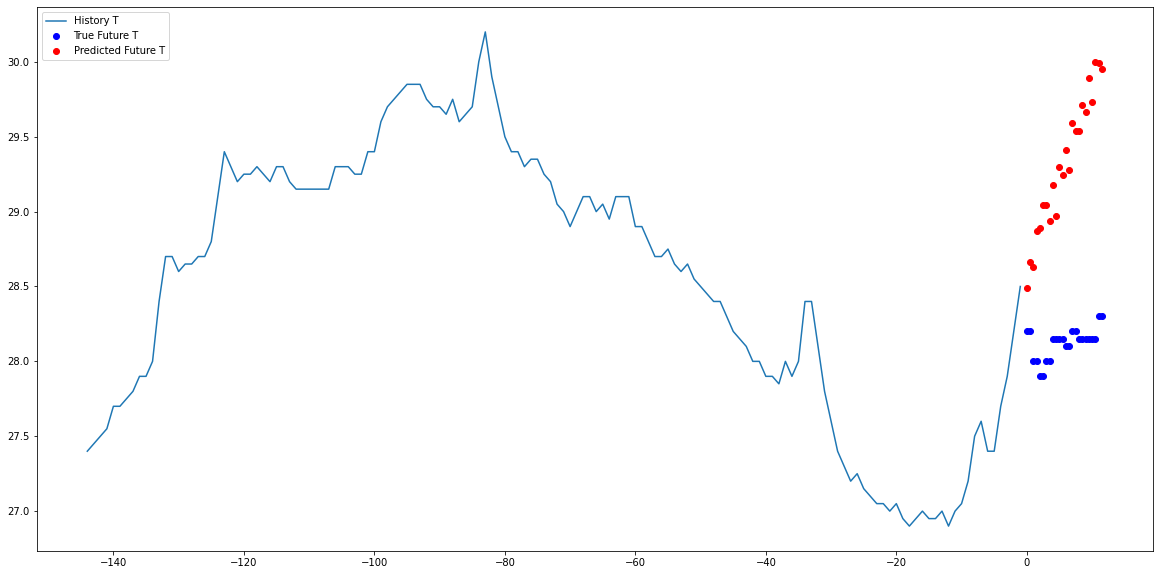

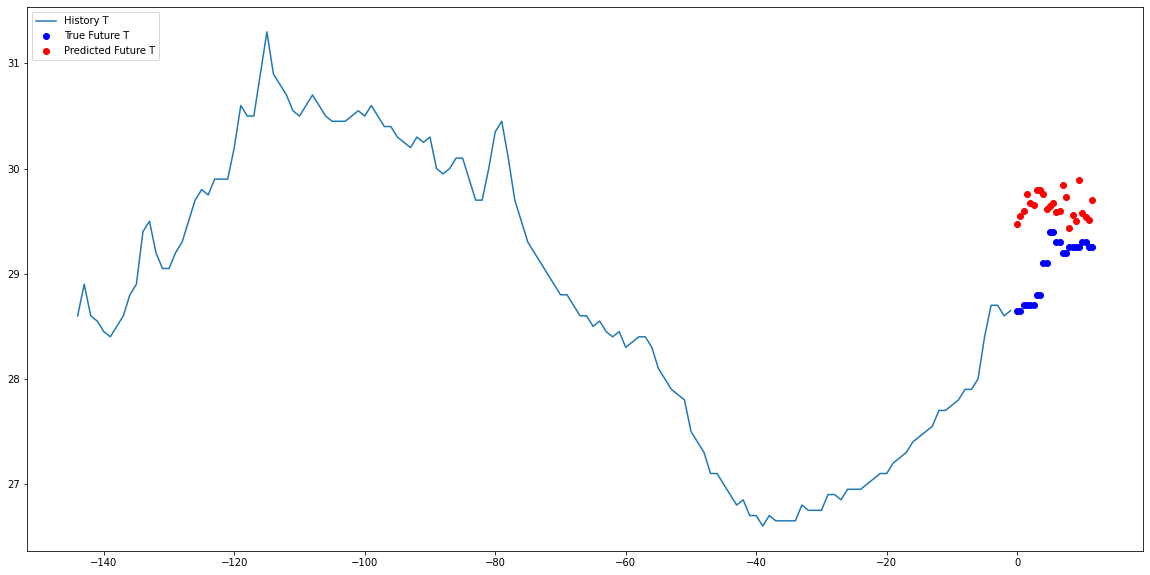

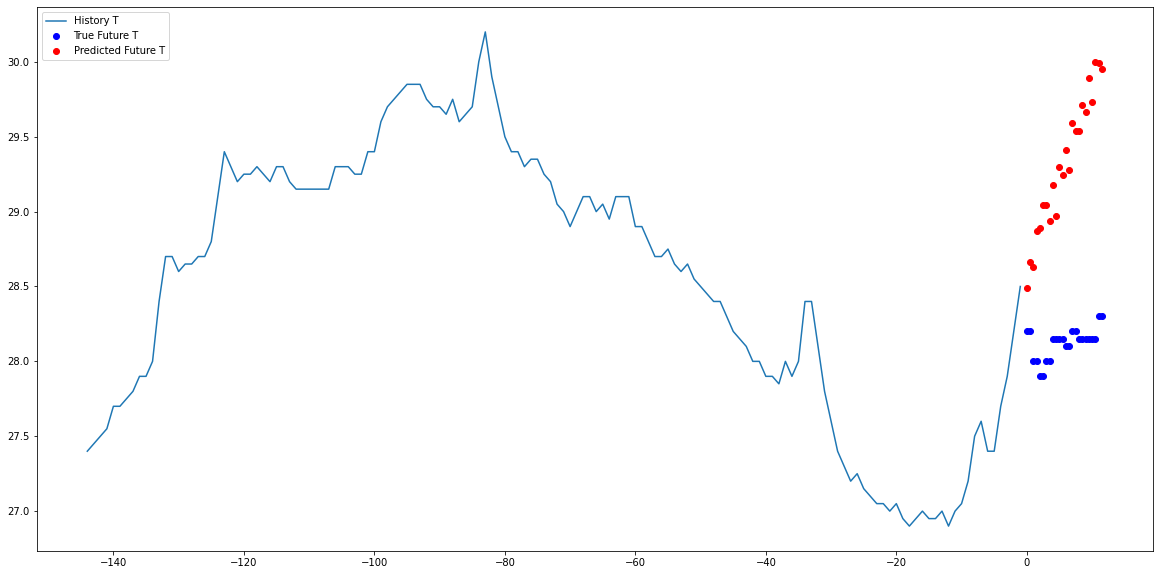

In [187]:
for x, y in val_data_multi.take(4):

  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])